# CellViT Classification Dataset — Patch and Label Generation

**Purpose:**  
This notebook prepares **128×128 classification patches** specifically for  
the *CellViT classification head*. Each patch contains cropped H&E tissue  
and a corresponding label file listing nucleus centers and classes.

---

### What It Does
1. Loads processed maps (`inst_map`, `type_map`) from `whole_slide/`.
2. Locates the corresponding RGB `.svs` or `.tif` image.
3. Tiles the slide into non-overlapping 128×128 patches.
4. For each patch:
   - Saves an RGB patch (`.png`)
   - Extracts nucleus centroids and class IDs → saves as `.csv`
5. Produces a clean folder structure compatible with CellViT’s training pipeline.
6. Generate `inst_map` & `type_map` for 128x128 patches

---

### Output Folder Structure
ProcessedDataset/

└── v1_40x_area20/

└── patches_cellvit_p128/

├── images/ ← 128×128 cropped RGB patches

├── labels/ ← matching .csv files with x,y,class

├── debug/ ← visualization or QA exports

└── _meta/ ← configuration and logs


---

### Table of Contents
- [Step 1 — Setup and Folder Creation](#step1)
- [Step 2 — Patch Extraction and Label Generation](#step2)
- [Step 3 — Visual Inspection of Generated Patches](#step3)
- [Step 4 — Summary and Quality Checks](#step4)
- [Step 5 — Dataset Integrity + Overview](#step5)
- [Step 6 — Crop and save 128×128 patch-level inst/type maps](#step6)



<a id="step1"></a>
# Step 1 — Setup and Folder Creation


In [1]:
from pathlib import Path
import json
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Config ---
PROJECT_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = PROJECT_ROOT / "ProcessedDataset/v1_40x_area20_2"
PATCH_SIZE = 128
TASK_NAME = f"patches_cellvit_p{PATCH_SIZE}"

# --- Input directories ---
RAW_IMG_ROOT = PROJECT_ROOT / "Datasets/BU_course_data/TrainingData/TrainingImages_and_Annotations"
INST_DIR = PROC_ROOT / "whole_slide/inst_maps"
TYPE_DIR = PROC_ROOT / "whole_slide/type_maps"

# --- Output directories ---
PATCH_ROOT = PROC_ROOT / TASK_NAME
(PATCH_ROOT / "images").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "labels").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "debug").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "_meta").mkdir(parents=True, exist_ok=True)

# --- Metadata loading ---
with open(PROC_ROOT / "_meta/class_map.json", "r") as f:
    class_map = json.load(f)

# --- Record run parameters ---
params = {
    "task": "cellvit_classification_head",
    "patch_size": PATCH_SIZE,
    "input_root": str(PROC_ROOT),
    "output_root": str(PATCH_ROOT),
    "num_classes": len(class_map),
    "class_map": class_map,
}

with open(PATCH_ROOT / "_meta/params.json", "w") as f:
    json.dump(params, f, indent=2)

# --- Confirmation ---
print(f"✅ Initialized output structure for CellViT classification patches:")
print(f"  → {PATCH_ROOT}")
print(f"  Classes: {list(class_map.values())}")


✅ Initialized output structure for CellViT classification patches:
  → /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128
  Classes: ['background', 'epithelial', 'lymphocyte', 'macrophage', 'neutrophil']


<a id="step2"></a>
# Step 2 — Patch Extraction and Label Generation

In [2]:
from skimage.measure import regionprops
import cv2
from openslide import OpenSlide

def find_image_path(slide_name: str) -> Path | None:
    """
    Locate the corresponding .svs (preferred) or .tif file for a given slide.
    """
    for patient_dir in sorted(RAW_IMG_ROOT.iterdir()):
        if not patient_dir.is_dir():
            continue
        for ext in (".svs", ".tif"):
            candidate = patient_dir / f"{slide_name}{ext}"
            if candidate.exists():
                return candidate
    return None


def load_rgb_image(img_path: Path) -> np.ndarray:
    """
    Load RGB image using OpenSlide (.svs) or OpenCV (.tif).
    """
    if img_path.suffix.lower() == ".svs":
        with OpenSlide(str(img_path)) as slide:
            w, h = slide.level_dimensions[0]
            rgb = np.array(slide.read_region((0, 0), 0, (w, h)))[:, :, :3]
        return rgb
    else:
        img = cv2.imread(str(img_path))
        if img is None:
            raise RuntimeError(f"Failed to load {img_path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def extract_patch_labels(inst_map: np.ndarray, type_map: np.ndarray):
    """
    Return (x, y, class_id) for each nucleus centroid.
    """
    rows = []
    for region in regionprops(inst_map):
        y, x = region.centroid
        cls_vals = type_map[inst_map == region.label]
        if cls_vals.size == 0:
            continue
        cls = int(np.bincount(cls_vals).argmax())  # majority vote
        if cls == 0:
            continue  # skip background
        rows.append((int(x), int(y), cls))
    return rows


# --- Main loop ---
slides = sorted([p.stem.replace("_inst", "") for p in INST_DIR.glob("*_inst.npy")])
print(f"Found {len(slides)} processed slides.")

for slide_name in tqdm(slides, desc="Generating patches"):
    inst_path = INST_DIR / f"{slide_name}_inst.npy"
    type_path = TYPE_DIR / f"{slide_name}_type.npy"

    if not inst_path.exists() or not type_path.exists():
        print(f"⚠️ Missing maps for {slide_name}")
        continue

    try:
        inst_map = np.load(inst_path)
        type_map = np.load(type_path)
        img_path = find_image_path(slide_name)
        if img_path is None:
            print(f"⚠️ No image found for {slide_name}")
            continue
        rgb = load_rgb_image(img_path)

        h, w = rgb.shape[:2]
        saved_count = 0

        for y in range(0, h, PATCH_SIZE):
            for x in range(0, w, PATCH_SIZE):
                patch_rgb = rgb[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                patch_inst = inst_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                patch_type = type_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

                if patch_rgb.shape[0] != PATCH_SIZE or patch_rgb.shape[1] != PATCH_SIZE:
                    continue  # skip incomplete edge tiles

                # skip empty patches
                if np.count_nonzero(patch_inst) == 0:
                    continue

                # extract centers
                centers = extract_patch_labels(patch_inst, patch_type)
                if not centers:
                    continue

                # save patch
                img_name = f"{slide_name}_{x}_{y}.png"
                csv_name = f"{slide_name}_{x}_{y}.csv"

                cv2.imwrite(str(PATCH_ROOT / "images" / img_name), cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2BGR))
                pd.DataFrame(centers, columns=["x", "y", "class"]).to_csv(
                    PATCH_ROOT / "labels" / csv_name, index=False, header=False
                )
                saved_count += 1

        print(f"Saved {saved_count} patches from {slide_name}")

    except Exception as e:
        print(f"⚠️ Error in {slide_name}: {e}")

print("✅ Patch generation complete.")


Found 209 processed slides.


Generating patches:   1%|          | 2/209 [00:00<01:11,  2.88it/s]

Saved 64 patches from TCGA-55-1594-01Z-00-DX1_001
Saved 16 patches from TCGA-55-1594-01Z-00-DX1_002


Generating patches:   2%|▏         | 4/209 [00:01<00:40,  5.09it/s]

Saved 13 patches from TCGA-55-1594-01Z-00-DX1_003
Saved 14 patches from TCGA-55-1594-01Z-00-DX1_004


Generating patches:   2%|▏         | 5/209 [00:01<00:36,  5.59it/s]

Saved 16 patches from TCGA-55-1594-01Z-00-DX1_005


Generating patches:   3%|▎         | 7/209 [00:01<00:43,  4.68it/s]

Saved 90 patches from TCGA-5P-A9K0-01Z-00-DX1_1
Saved 25 patches from TCGA-5P-A9K0-01Z-00-DX1_2
Saved 1 patches from TCGA-5P-A9K0-01Z-00-DX1_3


Generating patches:   5%|▍         | 10/209 [00:01<00:26,  7.49it/s]

Saved 10 patches from TCGA-69-7760-01Z-00-DX1_001
Saved 12 patches from TCGA-69-7760-01Z-00-DX1_002


Generating patches:   5%|▌         | 11/209 [00:02<00:25,  7.68it/s]

Saved 16 patches from TCGA-69-7760-01Z-00-DX1_003


Generating patches:   6%|▌         | 12/209 [00:02<00:45,  4.30it/s]

Saved 64 patches from TCGA-69-7760-01Z-00-DX1_004
Saved 1 patches from TCGA-69-A59K-01Z-00-DX1_001
Saved 3 patches from TCGA-69-A59K-01Z-00-DX1_002


Generating patches:   7%|▋         | 15/209 [00:04<01:17,  2.49it/s]

Saved 171 patches from TCGA-69-A59K-01Z-00-DX1_003


Generating patches:   8%|▊         | 17/209 [00:04<01:02,  3.06it/s]

Saved 25 patches from TCGA-69-A59K-01Z-00-DX1_004
Saved 13 patches from TCGA-73-4668-01Z-00-DX1_001


Generating patches:   9%|▊         | 18/209 [00:05<01:09,  2.75it/s]

Saved 63 patches from TCGA-73-4668-01Z-00-DX1_002
Saved 2 patches from TCGA-73-4668-01Z-00-DX1_003


Generating patches:  11%|█         | 22/209 [00:05<00:36,  5.09it/s]

Saved 14 patches from TCGA-73-4668-01Z-00-DX1_004
Saved 8 patches from TCGA-78-7220-01Z-00-DX1_001
Saved 7 patches from TCGA-78-7220-01Z-00-DX1_002


Generating patches:  11%|█▏        | 24/209 [00:06<00:42,  4.37it/s]

Saved 64 patches from TCGA-78-7220-01Z-00-DX1_003
Saved 16 patches from TCGA-78-7220-01Z-00-DX1_004


Generating patches:  12%|█▏        | 25/209 [00:06<00:36,  4.98it/s]

Saved 5 patches from TCGA-86-7713-01Z-00-DX1_001


Generating patches:  12%|█▏        | 26/209 [00:06<00:39,  4.66it/s]

Saved 18 patches from TCGA-86-7713-01Z-00-DX1_002


Generating patches:  13%|█▎        | 27/209 [00:06<00:41,  4.35it/s]

Saved 24 patches from TCGA-86-7713-01Z-00-DX1_003


Generating patches:  13%|█▎        | 28/209 [00:07<01:00,  2.99it/s]

Saved 63 patches from TCGA-86-7713-01Z-00-DX1_004


Generating patches:  14%|█▍        | 29/209 [00:07<00:54,  3.32it/s]

Saved 20 patches from TCGA-86-8672-01Z-00-DX1_1


Generating patches:  14%|█▍        | 30/209 [00:08<01:11,  2.50it/s]

Saved 51 patches from TCGA-86-8672-01Z-00-DX1_2


Generating patches:  15%|█▌        | 32/209 [00:09<01:15,  2.33it/s]

Saved 110 patches from TCGA-86-8672-01Z-00-DX1_3
Saved 16 patches from TCGA-A2-A0CV-01Z-00-DX1_1


Generating patches:  16%|█▌        | 33/209 [00:09<01:01,  2.84it/s]

Saved 20 patches from TCGA-A2-A0CV-01Z-00-DX1_2
Saved 1 patches from TCGA-A2-A0CV-01Z-00-DX1_3


Generating patches:  17%|█▋        | 35/209 [00:09<00:44,  3.94it/s]

Saved 30 patches from TCGA-A2-A0CV-01Z-00-DX1_4
Saved 1 patches from TCGA-A2-A0CV-01Z-00-DX1_5
Saved 6 patches from TCGA-A2-A0ES-01Z-00-DX1_1


Generating patches:  18%|█▊        | 38/209 [00:10<00:35,  4.82it/s]

Saved 45 patches from TCGA-A2-A0ES-01Z-00-DX1_2
Saved 1 patches from TCGA-A2-A0ES-01Z-00-DX1_3


Generating patches:  19%|█▉        | 40/209 [00:10<00:34,  4.96it/s]

Saved 47 patches from TCGA-A2-A0ES-01Z-00-DX1_4
Saved 9 patches from TCGA-A2-A0ES-01Z-00-DX1_5


Generating patches:  22%|██▏       | 45/209 [00:11<00:32,  5.11it/s]

Saved 105 patches from TCGA-B6-A0WZ-01Z-00-DX1_1
Saved 5 patches from TCGA-B6-A0WZ-01Z-00-DX1_2
Saved 2 patches from TCGA-B6-A0WZ-01Z-00-DX1_3
Saved 6 patches from TCGA-B6-A0WZ-01Z-00-DX1_4


Generating patches:  23%|██▎       | 48/209 [00:11<00:23,  6.73it/s]

Saved 19 patches from TCGA-B6-A0WZ-01Z-00-DX1_5
Saved 3 patches from TCGA-B6-A0WZ-01Z-00-DX1_6
Saved 12 patches from TCGA-B9-A44B-01Z-00-DX1_1


Generating patches:  24%|██▍       | 50/209 [00:12<00:25,  6.23it/s]

Saved 88 patches from TCGA-B9-A44B-01Z-00-DX1_2
Saved 0 patches from TCGA-B9-A44B-01Z-00-DX1_3


Generating patches:  25%|██▍       | 52/209 [00:12<00:31,  4.91it/s]

Saved 103 patches from TCGA-B9-A8YI-01Z-00-DX1_1
Saved 45 patches from TCGA-B9-A8YI-01Z-00-DX1_2


Generating patches:  25%|██▌       | 53/209 [00:13<00:42,  3.71it/s]

Saved 117 patches from TCGA-B9-A8YI-01Z-00-DX1_3
Saved 2 patches from TCGA-B9-A8YI-01Z-00-DX1_4
Saved 2 patches from TCGA-B9-A8YI-01Z-00-DX1_5


Generating patches:  27%|██▋       | 57/209 [00:14<00:33,  4.53it/s]

Saved 68 patches from TCGA-BH-A18T-01Z-00-DX1_1
Saved 16 patches from TCGA-BH-A18T-01Z-00-DX1_2


Generating patches:  28%|██▊       | 59/209 [00:14<00:25,  5.89it/s]

Saved 7 patches from TCGA-BH-A18T-01Z-00-DX1_3
Saved 6 patches from TCGA-BH-A18T-01Z-00-DX1_4


Generating patches:  29%|██▊       | 60/209 [00:14<00:30,  4.93it/s]

Saved 42 patches from TCGA-BH-A18T-01Z-00-DX1_5


Generating patches:  29%|██▉       | 61/209 [00:15<00:42,  3.46it/s]

Saved 63 patches from TCGA-BH-A18T-01Z-00-DX1_6
Saved 2 patches from TCGA-D8-A1X5-01Z-00-DX2_1


Generating patches:  30%|███       | 63/209 [00:15<00:37,  3.94it/s]

Saved 71 patches from TCGA-D8-A1X5-01Z-00-DX2_2


Generating patches:  31%|███       | 65/209 [00:16<00:39,  3.67it/s]

Saved 126 patches from TCGA-D8-A1X5-01Z-00-DX2_3
Saved 13 patches from TCGA-D8-A1X5-01Z-00-DX2_4


Generating patches:  32%|███▏      | 67/209 [00:16<00:33,  4.22it/s]

Saved 36 patches from TCGA-DW-7841-01Z-00-DX1_1
Saved 42 patches from TCGA-DW-7841-01Z-00-DX1_2


Generating patches:  33%|███▎      | 70/209 [00:16<00:18,  7.55it/s]

Saved 6 patches from TCGA-DW-7841-01Z-00-DX1_3
Saved 9 patches from TCGA-E2-A154-01Z-00-DX1_1
Saved 2 patches from TCGA-E2-A154-01Z-00-DX1_2
Saved 16 patches from TCGA-E2-A154-01Z-00-DX1_3


Generating patches:  34%|███▍      | 72/209 [00:17<00:17,  7.65it/s]

Saved 16 patches from TCGA-E2-A154-01Z-00-DX1_4
Saved 12 patches from TCGA-E2-A154-01Z-00-DX1_5
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_6
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_7
Saved 1 patches from TCGA-E2-A154-01Z-00-DX1_8


Generating patches:  37%|███▋      | 78/209 [00:18<00:22,  5.88it/s]

Saved 101 patches from TCGA-E9-A22B-01Z-00-DX1_1
Saved 18 patches from TCGA-E9-A22B-01Z-00-DX1_2


Generating patches:  40%|███▉      | 83/209 [00:18<00:14,  8.94it/s]

Saved 30 patches from TCGA-E9-A22B-01Z-00-DX1_3
Saved 4 patches from TCGA-E9-A22B-01Z-00-DX1_4
Saved 1 patches from TCGA-E9-A22B-01Z-00-DX1_5
Saved 3 patches from TCGA-E9-A22B-01Z-00-DX1_6
Saved 0 patches from TCGA-E9-A22B-01Z-00-DX1_7


Generating patches:  41%|████      | 85/209 [00:19<00:21,  5.71it/s]

Saved 66 patches from TCGA-E9-A22B-01Z-00-DX1_8
Saved 16 patches from TCGA-E9-A22G-01Z-00-DX1_1


Generating patches:  42%|████▏     | 87/209 [00:19<00:20,  6.07it/s]

Saved 20 patches from TCGA-E9-A22G-01Z-00-DX1_2
Saved 6 patches from TCGA-E9-A22G-01Z-00-DX1_3
Saved 4 patches from TCGA-E9-A22G-01Z-00-DX1_4


Generating patches:  43%|████▎     | 89/209 [00:19<00:18,  6.42it/s]

Saved 24 patches from TCGA-E9-A22G-01Z-00-DX1_5


Generating patches:  44%|████▍     | 92/209 [00:20<00:19,  5.90it/s]

Saved 131 patches from TCGA-EJ-5495-01Z-00-DX1-1
Saved 15 patches from TCGA-EJ-5495-01Z-00-DX1-2
Saved 6 patches from TCGA-EJ-5495-01Z-00-DX1-3
Saved 3 patches from TCGA-EJ-5495-01Z-00-DX1-4


Generating patches:  47%|████▋     | 98/209 [00:20<00:10, 10.25it/s]

Saved 56 patches from TCGA-EJ-5505-01Z-00-DX1-1
Saved 4 patches from TCGA-EJ-5505-01Z-00-DX1-2
Saved 3 patches from TCGA-EJ-5505-01Z-00-DX1-3
Saved 5 patches from TCGA-EJ-5505-01Z-00-DX1-4
Saved 3 patches from TCGA-EJ-5505-01Z-00-DX1-5
Saved 2 patches from TCGA-EJ-5505-01Z-00-DX1-6


Generating patches:  49%|████▉     | 102/209 [00:21<00:08, 13.03it/s]

Saved 11 patches from TCGA-EJ-5517-01Z-00-DX1-1
Saved 0 patches from TCGA-EJ-5517-01Z-00-DX1-2
Saved 13 patches from TCGA-EJ-5517-01Z-00-DX1-3
Saved 149 patches from TCGA-EJ-5517-01Z-00-DX1-4


Generating patches:  51%|█████     | 106/209 [00:22<00:13,  7.50it/s]

Saved 54 patches from TCGA-EV-5903-01Z-00-DX1_1
Saved 21 patches from TCGA-EV-5903-01Z-00-DX1_2
Saved 1 patches from TCGA-EV-5903-01Z-00-DX1_3
Saved 4 patches from TCGA-EV-5903-01Z-00-DX1_4


Generating patches:  53%|█████▎    | 110/209 [00:22<00:09, 10.81it/s]

Saved 2 patches from TCGA-EV-5903-01Z-00-DX1_5
Saved 1 patches from TCGA-EW-A6SD-01Z-00-DX1_1
Saved 0 patches from TCGA-EW-A6SD-01Z-00-DX1_2
Saved 40 patches from TCGA-EW-A6SD-01Z-00-DX1_3


Generating patches:  54%|█████▎    | 112/209 [00:23<00:15,  6.31it/s]

Saved 36 patches from TCGA-EW-A6SD-01Z-00-DX1_4
Saved 12 patches from TCGA-EW-A6SD-01Z-00-DX1_5


Generating patches:  56%|█████▌    | 116/209 [00:23<00:13,  7.00it/s]

Saved 63 patches from TCGA-F9-A97G-01Z-00-DX1_1
Saved 1 patches from TCGA-F9-A97G-01Z-00-DX1_2
Saved 20 patches from TCGA-F9-A97G-01Z-00-DX1_3
Saved 4 patches from TCGA-F9-A97G-01Z-00-DX1_4


Generating patches:  59%|█████▉    | 123/209 [00:23<00:06, 13.46it/s]

Saved 7 patches from TCGA-G7-A8LD-01Z-00-DX1_1
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_10
Saved 1 patches from TCGA-G7-A8LD-01Z-00-DX1_2
Saved 1 patches from TCGA-G7-A8LD-01Z-00-DX1_3
Saved 1 patches from TCGA-G7-A8LD-01Z-00-DX1_4
Saved 7 patches from TCGA-G7-A8LD-01Z-00-DX1_5
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_6
Saved 3 patches from TCGA-G7-A8LD-01Z-00-DX1_7


Generating patches:  62%|██████▏   | 129/209 [00:24<00:04, 18.70it/s]

Saved 7 patches from TCGA-G7-A8LD-01Z-00-DX1_8
Saved 4 patches from TCGA-G7-A8LD-01Z-00-DX1_9
Saved 1 patches from TCGA-G9-6342-01Z-00-DX1-1
Saved 6 patches from TCGA-G9-6342-01Z-00-DX1-2


Generating patches:  63%|██████▎   | 132/209 [00:24<00:04, 15.70it/s]

Saved 27 patches from TCGA-G9-6499-01Z-00-DX1-1
Saved 12 patches from TCGA-G9-6499-01Z-00-DX1-2
Saved 6 patches from TCGA-G9-6499-01Z-00-DX1-3
Saved 94 patches from TCGA-G9-6499-01Z-00-DX1-4
Saved 6 patches from TCGA-G9-6499-01Z-00-DX1-5


Generating patches:  66%|██████▌   | 137/209 [00:25<00:06, 10.65it/s]

Saved 42 patches from TCGA-J4-A67Q-01Z-00-DX1-1
Saved 2 patches from TCGA-J4-A67Q-01Z-00-DX1-2
Saved 15 patches from TCGA-J4-A67Q-01Z-00-DX1-3
Saved 9 patches from TCGA-J4-A67Q-01Z-00-DX1-4
Saved 2 patches from TCGA-J4-A67Q-01Z-00-DX1-5


Generating patches:  67%|██████▋   | 140/209 [00:25<00:05, 12.67it/s]

Saved 12 patches from TCGA-J4-A67T-01Z-00-DX1-1


Generating patches:  69%|██████▉   | 145/209 [00:25<00:04, 13.33it/s]

Saved 48 patches from TCGA-J4-A67T-01Z-00-DX1-2
Saved 1 patches from TCGA-J4-A67T-01Z-00-DX1-3
Saved 0 patches from TCGA-J4-A67T-01Z-00-DX1-4
Saved 4 patches from TCGA-J4-A67T-01Z-00-DX1-5
Saved 16 patches from TCGA-J4-A67T-01Z-00-DX1-6


Generating patches:  70%|███████   | 147/209 [00:25<00:05, 12.01it/s]

Saved 16 patches from TCGA-KK-A59X-01Z-00-DX1-1
Saved 12 patches from TCGA-KK-A59X-01Z-00-DX1-2
Saved 1 patches from TCGA-KK-A59X-01Z-00-DX1-3


Generating patches:  71%|███████▏  | 149/209 [00:25<00:04, 12.06it/s]

Saved 28 patches from TCGA-KK-A6E0-01Z-00-DX1-1


Generating patches:  74%|███████▎  | 154/209 [00:26<00:04, 11.76it/s]

Saved 48 patches from TCGA-KK-A6E0-01Z-00-DX1-2
Saved 6 patches from TCGA-KK-A6E0-01Z-00-DX1-3
Saved 0 patches from TCGA-KK-A6E0-01Z-00-DX1-4
Saved 5 patches from TCGA-KK-A6E0-01Z-00-DX1-5
Saved 16 patches from TCGA-KK-A7AW-01Z-00-DX1-1


Generating patches:  75%|███████▍  | 156/209 [00:26<00:06,  8.82it/s]

Saved 30 patches from TCGA-L4-A4E5-01Z-00-DX1_1
Saved 10 patches from TCGA-L4-A4E5-01Z-00-DX1_2


Generating patches:  76%|███████▌  | 158/209 [00:27<00:07,  7.22it/s]

Saved 49 patches from TCGA-L4-A4E5-01Z-00-DX1_3
Saved 9 patches from TCGA-MH-A560-01Z-00-DX2_1


Generating patches:  78%|███████▊  | 162/209 [00:27<00:06,  7.22it/s]

Saved 147 patches from TCGA-MH-A560-01Z-00-DX2_2
Saved 4 patches from TCGA-MH-A560-01Z-00-DX2_3
Saved 1 patches from TCGA-MH-A560-01Z-00-DX2_4
Saved 6 patches from TCGA-MP-A4SY-01Z-00-DX1_1


Generating patches:  78%|███████▊  | 164/209 [00:28<00:09,  4.81it/s]

Saved 64 patches from TCGA-MP-A4SY-01Z-00-DX1_2
Saved 16 patches from TCGA-MP-A4SY-01Z-00-DX1_3


Generating patches:  79%|███████▉  | 165/209 [00:28<00:08,  5.09it/s]

Saved 14 patches from TCGA-MP-A4SY-01Z-00-DX1_4
Saved 1 patches from TCGA-MP-A4T7-01Z-00-DX1_1
Saved 4 patches from TCGA-MP-A4T7-01Z-00-DX1_2


Generating patches:  81%|████████  | 169/209 [00:29<00:07,  5.28it/s]

Saved 42 patches from TCGA-MP-A4T7-01Z-00-DX1_3
Saved 18 patches from TCGA-MP-A4T7-01Z-00-DX1_4


Generating patches:  82%|████████▏ | 171/209 [00:29<00:05,  6.87it/s]

Saved 12 patches from TCGA-P4-AAVK-01Z-00-DX1_1
Saved 4 patches from TCGA-P4-AAVK-01Z-00-DX1_2


Generating patches:  83%|████████▎ | 173/209 [00:30<00:06,  5.31it/s]

Saved 132 patches from TCGA-P4-AAVK-01Z-00-DX1_3
Saved 4 patches from TCGA-P4-AAVK-01Z-00-DX1_4
Saved 4 patches from TCGA-P4-AAVK-01Z-00-DX1_5
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_6
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_7


Generating patches:  85%|████████▍ | 177/209 [00:30<00:05,  5.41it/s]

Saved 71 patches from TCGA-S3-AA11-01Z-00-DX1_1


Generating patches:  85%|████████▌ | 178/209 [00:31<00:08,  3.51it/s]

Saved 103 patches from TCGA-S3-AA11-01Z-00-DX1_2


Generating patches:  86%|████████▌ | 179/209 [00:31<00:08,  3.66it/s]

Saved 19 patches from TCGA-S3-AA11-01Z-00-DX1_3


Generating patches:  87%|████████▋ | 181/209 [00:32<00:06,  4.32it/s]

Saved 24 patches from TCGA-S3-AA11-01Z-00-DX1_4
Saved 9 patches from TCGA-S3-AA11-01Z-00-DX1_5
Saved 1 patches from TCGA-S3-AA11-01Z-00-DX1_6


Generating patches:  89%|████████▊ | 185/209 [00:32<00:03,  7.14it/s]

Saved 21 patches from TCGA-SX-A7SR-01Z-00-DX1_1
Saved 18 patches from TCGA-SX-A7SR-01Z-00-DX1_2
Saved 10 patches from TCGA-UZ-A9PO-01Z-00-DX1_1
Saved 3 patches from TCGA-UZ-A9PO-01Z-00-DX1_2


Generating patches:  90%|█████████ | 189/209 [00:33<00:02,  9.36it/s]

Saved 49 patches from TCGA-UZ-A9PO-01Z-00-DX1_3
Saved 19 patches from TCGA-UZ-A9PO-01Z-00-DX1_4
Saved 2 patches from TCGA-UZ-A9PO-01Z-00-DX1_5
Saved 1 patches from TCGA-UZ-A9PO-01Z-00-DX1_6
Saved 1 patches from TCGA-UZ-A9PO-01Z-00-DX1_7
Saved 4 patches from TCGA-UZ-A9PU-01Z-00-DX1_1


Generating patches:  93%|█████████▎| 195/209 [00:33<00:01, 13.32it/s]

Saved 4 patches from TCGA-UZ-A9PU-01Z-00-DX1_2
Saved 20 patches from TCGA-V1-A8WL-01Z-00-DX1-1
Saved 17 patches from TCGA-V1-A8WL-01Z-00-DX1-2
Saved 0 patches from TCGA-V1-A8WL-01Z-00-DX1-3


Generating patches:  94%|█████████▍| 197/209 [00:33<00:00, 14.15it/s]

Saved 20 patches from TCGA-V1-A9O9-01Z-00-DX1-1
Saved 20 patches from TCGA-V1-A9O9-01Z-00-DX1-2


Generating patches:  97%|█████████▋| 202/209 [00:33<00:00, 13.40it/s]

Saved 42 patches from TCGA-V1-A9O9-01Z-00-DX1-3
Saved 4 patches from TCGA-V1-A9O9-01Z-00-DX1-4
Saved 4 patches from TCGA-V1-A9O9-01Z-00-DX1-5
Saved 9 patches from TCGA-X4-A8KQ-01Z-00-DX8-1
Saved 4 patches from TCGA-X4-A8KQ-01Z-00-DX8-2
Saved 2 patches from TCGA-X4-A8KQ-01Z-00-DX8-3


Generating patches:  98%|█████████▊| 205/209 [00:34<00:00, 10.67it/s]

Saved 71 patches from TCGA-YL-A9WY-01Z-00-DX1-1
Saved 36 patches from TCGA-YL-A9WY-01Z-00-DX1-2


Generating patches: 100%|██████████| 209/209 [00:34<00:00,  6.05it/s]

Saved 9 patches from TCGA-YL-A9WY-01Z-00-DX1-3
Saved 4 patches from TCGA-YL-A9WY-01Z-00-DX1-4
Saved 2 patches from TCGA-YL-A9WY-01Z-00-DX1-5
✅ Patch generation complete.


<a id="step3"></a>
# Step 3 — Visual Inspection of Generated Patches


In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from matplotlib.patches import Patch
import matplotlib

get_cmap = matplotlib.colormaps.get_cmap
cmap = get_cmap("Set2")
num_classes = len(class_map)
LUT = cmap(np.linspace(0, 1, num_classes))[:, :3]  # RGB LUT in [0,1]


patches = sorted(os.listdir(PATCH_ROOT / "images"))
print(f"Available patches: {len(patches)}")

def visualize_patch_with_gt(patch_name: str):
    if not patch_name:
        return
    clear_output(wait=True)
    print(f"Visualizing patch: {patch_name}")

    base_name = Path(patch_name).stem
    img_path  = PATCH_ROOT / "images" / f"{base_name}.png"
    csv_path  = PATCH_ROOT / "labels" / f"{base_name}.csv"

    parts = base_name.split("_")
    slide_name = "_".join(parts[:-2])
    x_off, y_off = map(int, parts[-2:])
    type_path = TYPE_DIR / f"{slide_name}_type.npy"

    if not type_path.exists() or not img_path.exists() or not csv_path.exists():
        print(f"Missing one of: {type_path.name}, {img_path.name}, {csv_path.name}")
        return

    type_map = np.load(type_path)
    type_patch = type_map[y_off:y_off+PATCH_SIZE, x_off:x_off+PATCH_SIZE]
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    df = pd.read_csv(csv_path, header=None, names=["x", "y", "class"])

    overlay = img.copy()
    for cls_id, grp in df.groupby("class"):
        color = (np.array(LUT[int(cls_id) % num_classes]) * 255).astype(int)
        for _, row in grp.iterrows():
            center = (int(row.x), int(row.y))
            cv2.circle(overlay, center, 4, (0, 0, 0), -1, lineType=cv2.LINE_AA)
            cv2.circle(overlay, center, 2, color.tolist(), -1, lineType=cv2.LINE_AA)

    tm_clipped = np.clip(type_patch, 0, num_classes - 1).astype(int)
    tm_color = (LUT[tm_clipped] * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img); axes[0].set_title("H&E Patch"); axes[0].axis("off")
    axes[1].imshow(tm_color); axes[1].set_title("Ground Truth Type Map"); axes[1].axis("off")
    axes[2].imshow(overlay); axes[2].set_title("Overlay (Labels on RGB)"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

    present = sorted(df["class"].unique())
    legend_patches = [
        Patch(color=LUT[int(c)], label=f"{int(c)}: {class_map[str(int(c))]}")
        for c in present
    ]
    plt.figure(figsize=(6, 0.6 + 0.3 * len(present)))
    plt.legend(handles=legend_patches, loc="center left",
               bbox_to_anchor=(0, 0.5), frameon=False, title="Cell Types")
    plt.axis("off")
    plt.show()

# --- Proper interactive output setup ---
dropdown = widgets.Dropdown(options=patches, description="Select Patch:")
out = widgets.interactive_output(visualize_patch_with_gt, {'patch_name': dropdown})

display(dropdown, out)


Available patches: 4871


Dropdown(description='Select Patch:', options=('TCGA-55-1594-01Z-00-DX1_001_0_0.png', 'TCGA-55-1594-01Z-00-DX1…

Output()

<a id="step4"></a>
# Step 4 — Dataset Summary & Integrity Checks

Saved summary: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/_meta/dataset_summary.csv
Total patches: 4871
Empty patches: 0 (0.0%)


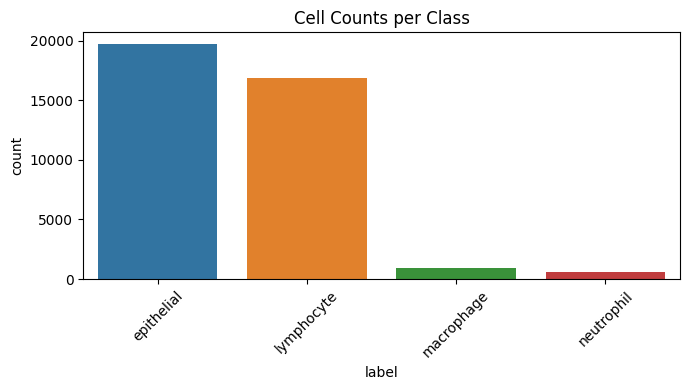

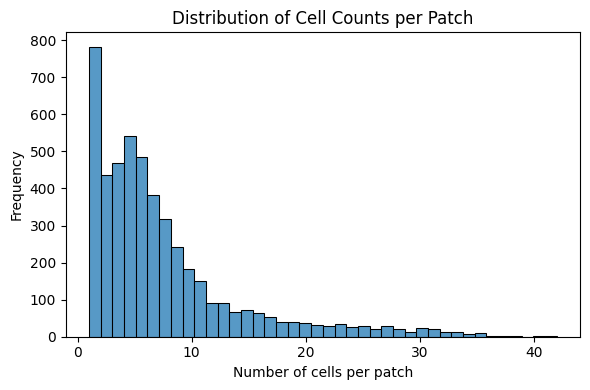

In [4]:
from collections import Counter
import seaborn as sns

patch_dir = PATCH_ROOT / "images"
label_dir = PATCH_ROOT / "labels"
meta_dir  = PROC_ROOT / "_meta"
meta_dir.mkdir(exist_ok=True)

records = []
class_counter = Counter()

for csv_file in sorted(label_dir.glob("*.csv")):
    base = csv_file.stem
    img_path = patch_dir / f"{base}.png"
    if not img_path.exists():
        continue

    df = pd.read_csv(csv_file, header=None, names=["x", "y", "class"])
    num_cells = len(df)
    class_counts = df["class"].value_counts().to_dict()

    for cls, n in class_counts.items():
        class_counter[int(cls)] += n

    records.append({
        "patch": base,
        "num_cells": num_cells,
        "unique_classes": list(class_counts.keys()),
        "empty": num_cells == 0
    })

summary_df = pd.DataFrame(records)
summary_df.to_csv(meta_dir / "dataset_summary.csv", index=False)
print(f"Saved summary: {meta_dir / 'dataset_summary.csv'}")

# --- Overview stats ---
total_patches = len(summary_df)
empty_patches = summary_df["empty"].sum()
print(f"Total patches: {total_patches}")
print(f"Empty patches: {empty_patches} ({empty_patches/total_patches:.1%})")

# --- Class distribution ---
class_df = pd.DataFrame.from_dict(class_counter, orient="index", columns=["count"])
class_df["label"] = class_df.index.map(lambda i: class_map.get(str(i), "unknown"))
class_df = class_df.sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x="label", y="count", data=class_df, palette="tab10")
plt.title("Cell Counts per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Cells per patch distribution ---
plt.figure(figsize=(6,4))
sns.histplot(summary_df["num_cells"], bins=40, kde=False)
plt.title("Distribution of Cell Counts per Patch")
plt.xlabel("Number of cells per patch")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


<a id="step5"></a>
# Step 5: Dataset Integrity + Overview

In [5]:
from collections import Counter
import pandas as pd
import numpy as np

print("🔍 Checking dataset integrity...")

images_dir = PATCH_ROOT / "images"
labels_dir = PATCH_ROOT / "labels"

image_files = sorted(f.stem for f in images_dir.glob("*.png"))
label_files = sorted(f.stem for f in labels_dir.glob("*.csv"))

# 1️⃣  File pairing
unmatched_images = set(image_files) - set(label_files)
unmatched_labels = set(label_files) - set(image_files)

print(f"Total images: {len(image_files)}")
print(f"Total labels: {len(label_files)}")
if unmatched_images:
    print(f"⚠️ {len(unmatched_images)} images without labels.")
if unmatched_labels:
    print(f"⚠️ {len(unmatched_labels)} labels without images.")

# 2️⃣  Validate CSV content (quick sample)
empty_labels = []
class_counter = Counter()
for csv_path in labels_dir.glob("*.csv"):
    try:
        data = np.loadtxt(csv_path, delimiter=",")
        if data.ndim == 1 and data.size == 0:
            empty_labels.append(csv_path.name)
        else:
            # 3rd column = class id
            cls = data[:, 2].astype(int) if data.ndim > 1 else []
            class_counter.update(cls.tolist())
    except Exception:
        empty_labels.append(csv_path.name)

print(f"Empty label files: {len(empty_labels)}")
if empty_labels:
    print("Example empty files:", empty_labels[:3])

# 3️⃣  Patch count per patient
# Ensure file stems are strings
file_series = pd.Series([str(f) for f in image_files])

patient_counts = (
    file_series
    .str.extract(r"(TCGA-[0-9A-Z-]+)")
    .dropna()[0]
    .value_counts()
)

print("\nPatch count per patient (top 5):")
print(patient_counts.head())


# 4️⃣  Class totals
print("\nClass pixel count summary:")
for cid, count in class_counter.items():
    name = class_map.get(str(cid), f"id_{cid}")
    print(f"  {cid} ({name}): {count}")

# 5️⃣  Save summary CSV
summary_path = PROC_ROOT / "_meta" / "final_summary.csv"
pd.DataFrame.from_dict(class_counter, orient="index", columns=["count"]).to_csv(summary_path)
print(f"\n✅ Final summary saved to: {summary_path}")


🔍 Checking dataset integrity...
Total images: 4871
Total labels: 4871
Empty label files: 382
Example empty files: ['TCGA-G9-6499-01Z-00-DX1-4_1280_256.csv', 'TCGA-86-8672-01Z-00-DX1_2_512_384.csv', 'TCGA-86-7713-01Z-00-DX1_002_0_0.csv']

Patch count per patient (top 5):
TCGA-B9-A8YI-01Z-00-DX1    269
TCGA-S3-AA11-01Z-00-DX1    227
TCGA-E9-A22B-01Z-00-DX1    223
TCGA-D8-A1X5-01Z-00-DX2    212
TCGA-BH-A18T-01Z-00-DX1    202
Name: 0, dtype: int64

Class pixel count summary:
  1 (epithelial): 19567
  3 (macrophage): 866
  2 (lymphocyte): 16775
  4 (neutrophil): 475

✅ Final summary saved to: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/_meta/final_summary.csv


<a id="step6"></a>
# Step 6: Generate 128×128 patch-level instance and type maps

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random

print("\nCropping 128x128 instance and type maps...")

from pathlib import Path
import json
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Config ---
PROJECT_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = PROJECT_ROOT / "ProcessedDataset/v1_40x_area20_2"
PATCH_SIZE = 128
TASK_NAME = f"patches_cellvit_p{PATCH_SIZE}"

# --- Input directories ---
RAW_IMG_ROOT = PROJECT_ROOT / "Datasets/BU_course_data/TrainingData/TrainingImages_and_Annotations"
INST_DIR = PROC_ROOT / "whole_slide/inst_maps"
TYPE_DIR = PROC_ROOT / "whole_slide/type_maps"

# --- Output directories ---
PATCH_ROOT = PROC_ROOT / TASK_NAME

PATCH_SIZE = 128
patch_map_dir = PATCH_ROOT / "patch_label_maps"
patch_map_dir.mkdir(exist_ok=True)

slide_summaries = []

for inst_path in INST_DIR.glob("*_inst.npy"):
    slide_id = inst_path.stem.replace("_inst", "")
    type_path = TYPE_DIR / f"{slide_id}_type.npy"
    if not type_path.exists():
        print(f"⚠️ Missing type map for {slide_id}")
        continue

    inst_map = np.load(inst_path)
    type_map = np.load(type_path)
    h, w = inst_map.shape
    saved = 0

    for y in range(0, h, PATCH_SIZE):
        for x in range(0, w, PATCH_SIZE):
            patch_inst = inst_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            patch_type = type_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if patch_inst.shape != (PATCH_SIZE, PATCH_SIZE):
                continue
            if np.all(patch_type == 0):
                continue
            np.save(
                patch_map_dir / f"{slide_id}_{x}_{y}.npy",
                {"inst_map": patch_inst, "type_map": patch_type}
            )
            saved += 1

    slide_summaries.append({"slide": slide_id, "patch_maps": saved})
    print(f"{slide_id}: saved {saved} patch label maps")



Cropping 128x128 instance and type maps...
TCGA-B9-A8YI-01Z-00-DX1_3: saved 117 patch label maps
TCGA-E9-A22G-01Z-00-DX1_5: saved 24 patch label maps
TCGA-V1-A9O9-01Z-00-DX1-2: saved 20 patch label maps
TCGA-G9-6499-01Z-00-DX1-4: saved 94 patch label maps
TCGA-86-7713-01Z-00-DX1_004: saved 63 patch label maps
TCGA-EJ-5517-01Z-00-DX1-1: saved 11 patch label maps
TCGA-EV-5903-01Z-00-DX1_2: saved 21 patch label maps
TCGA-G9-6342-01Z-00-DX1-1: saved 1 patch label maps
TCGA-E9-A22B-01Z-00-DX1_6: saved 3 patch label maps
TCGA-EJ-5505-01Z-00-DX1-2: saved 4 patch label maps
TCGA-B6-A0WZ-01Z-00-DX1_5: saved 19 patch label maps
TCGA-EW-A6SD-01Z-00-DX1_1: saved 1 patch label maps
TCGA-J4-A67T-01Z-00-DX1-4: saved 0 patch label maps
TCGA-J4-A67T-01Z-00-DX1-6: saved 16 patch label maps
TCGA-UZ-A9PO-01Z-00-DX1_4: saved 19 patch label maps
TCGA-A2-A0ES-01Z-00-DX1_5: saved 9 patch label maps
TCGA-5P-A9K0-01Z-00-DX1_3: saved 1 patch label maps
TCGA-G7-A8LD-01Z-00-DX1_1: saved 7 patch label maps
TCGA-73


✅ Patch-level maps saved to: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128/patch_label_maps
Summary written to: _meta/patch_label_summary.csv


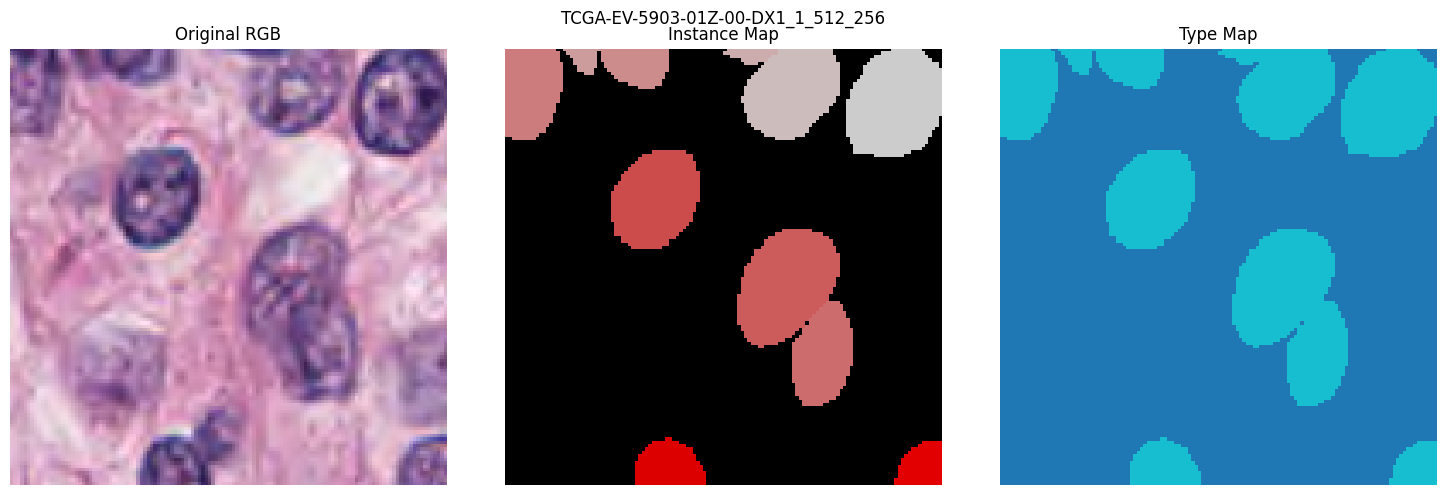

In [8]:
# --- Summary ---
import pandas as pd
summary_df = pd.DataFrame(slide_summaries)
summary_df.to_csv(PROC_ROOT / "_meta" / "patch_label_summary.csv", index=False)
print(f"\n✅ Patch-level maps saved to: {patch_map_dir}")
print(f"Summary written to: _meta/patch_label_summary.csv")

# --- Quick visual sanity check ---
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# pick a random patch label map
sample = random.choice(list(patch_map_dir.glob("*.npy")))
data = np.load(sample, allow_pickle=True).item()
inst, typ = data["inst_map"], data["type_map"]

# infer corresponding RGB image file
# e.g. slide_id_x_y.npy → slide_id_x_y.png
img_name = sample.stem + ".png"
img_path = PATCH_ROOT / "images" / img_name

rgb = None
if img_path.exists():
    rgb = cv2.imread(str(img_path))
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
else:
    print(f"⚠️ No matching RGB image found for {img_name}")

plt.figure(figsize=(15,5))
if rgb is not None:
    plt.subplot(1,3,1); plt.imshow(rgb); plt.title("Original RGB"); plt.axis("off")

plt.subplot(1,3,2); plt.imshow(inst, cmap="nipy_spectral"); plt.title("Instance Map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(typ, cmap="tab10"); plt.title("Type Map"); plt.axis("off")
plt.suptitle(sample.stem)
plt.tight_layout()
plt.show()
